# Hyperparameter optimization

*Fraida Fund*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform

## Grid search

For models with a single hyperparameter controlling bias-variance (for example: $k$ in $k$ nearest neighbors), we used sklearns's `KFoldCV` or `validation_curve` to test a range of values for the hyperparameter, and to select the best one.

When we have *multiple* hyperparameters to tune, we can use `GridSearchCV` to select the best *combination* of them.

For example, we saw three ways to tune the bias-variance of an SVM classifier:

-   Changing the kernel
-   Changing $C$
-   For an RBF kernel, changing $\gamma$

To get the best performance from an SVM classifier, we need to find the best *combination* of these hyperparameters. This notebook shows how to use `GridSearchCV` to tune an SVM classifier.

We will work with a subset of the MNIST handwritten digits data. First, we will get the data, and assign a small subset of samples to training and test sets.

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True )

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=300)

Let’s try this initial parameter “grid”:

In [4]:
param_grid = [
  {'C': [0.1, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1000], 'gamma': [0.01, 0.0001], 'kernel': ['rbf']},
 ]
param_grid

[{'C': [0.1, 1000], 'kernel': ['linear']},
 {'C': [0.1, 1000], 'gamma': [0.01, 0.0001], 'kernel': ['rbf']}]

Now we’ll set up the grid search. We can use `fit` on it, just like any other `sklearn` model.

I added `return_train_score=True` to my `GridSearchSV` so that it will show me training scores as well:

In [5]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: total: 46.9 ms
Wall time: 5.73 s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1000], 'gamma': [0.01, 0.0001],
                          'kernel': ['rbf']}],
             return_train_score=True, verbose=100)

Here are the results:

In [6]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.133610,0.011384,0.099797,0.015761,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.859281,0.861862,0.831832,0.850992,0.013589,1,1.000000,1.000000,1.000000,1.00,0.000000
1,0.155217,0.007197,0.137934,0.011342,1000.0,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.859281,0.861862,0.831832,0.850992,0.013589,1,1.000000,1.000000,1.000000,1.00,0.000000
2,0.470480,0.044038,0.281979,0.023287,0.1,rbf,0.0100,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.128743,0.132132,0.129129,0.130001,0.001515,3,0.130631,0.128936,0.130435,0.13,0.000757
3,0.388682,0.009857,0.348046,0.011310,0.1,rbf,0.0001,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.128743,0.132132,0.129129,0.130001,0.001515,3,0.130631,0.128936,0.130435,0.13,0.000757
4,0.431545,0.010615,0.305108,0.024459,1000.0,rbf,0.0100,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.128743,0.132132,0.129129,0.130001,0.001515,3,1.000000,1.000000,1.000000,1.00,0.000000
5,0.402066,0.008872,0.371033,0.011538,1000.0,rbf,0.0001,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",0.128743,0.132132,0.129129,0.130001,0.001515,3,1.000000,1.000000,1.000000,1.00,0.000000


To inform our search, we will use our understanding of how SVMs work, and especially how the $C$ and $\gamma$ parameters control the bias and variance of the SVM.

### Linear kernel

Let’s tackle the linear SVM first, since it’s faster to fit. We didn’t see any change in the accuracy when we vary $C$. So, we should extend the range of $C$ over which we search.

I’ll try higher and lower values of $C$, to see what happens.

In [7]:
param_grid = [
  {'C': [1e-6, 1e-4, 1e-2, 1e2, 1e4, 1e6], 'kernel': ['linear']},
 ]
param_grid

[{'C': [1e-06, 0.0001, 0.01, 100.0, 10000.0, 1000000.0], 'kernel': ['linear']}]

In [8]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: total: 31.2 ms
Wall time: 2.17 s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1e-06, 0.0001, 0.01, 100.0, 10000.0, 1000000.0],
                          'kernel': ['linear']}],
             return_train_score=True, verbose=100)

In [9]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.091715,0.034020,0.086716,0.069645,0.000001,linear,"{'C': 1e-06, 'kernel': 'linear'}",0.853293,0.864865,0.849850,0.856003,0.006422,1,0.989489,0.994003,0.994003,0.992498,0.002128
1,0.170603,0.003528,0.191931,0.011516,0.000100,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.859281,0.861862,0.831832,0.850992,0.013589,2,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.224040,0.036775,0.224343,0.031592,0.010000,linear,"{'C': 0.01, 'kernel': 'linear'}",0.859281,0.861862,0.831832,0.850992,0.013589,2,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.210309,0.021656,0.218579,0.051462,100.000000,linear,"{'C': 100.0, 'kernel': 'linear'}",0.859281,0.861862,0.831832,0.850992,0.013589,2,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.215668,0.023942,0.223647,0.030539,10000.000000,linear,"{'C': 10000.0, 'kernel': 'linear'}",0.859281,0.861862,0.831832,0.850992,0.013589,2,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.229627,0.055552,0.203496,0.025194,1000000.000000,linear,"{'C': 1000000.0, 'kernel': 'linear'}",0.859281,0.861862,0.831832,0.850992,0.013589,2,1.000000,1.000000,1.000000,1.000000,0.000000


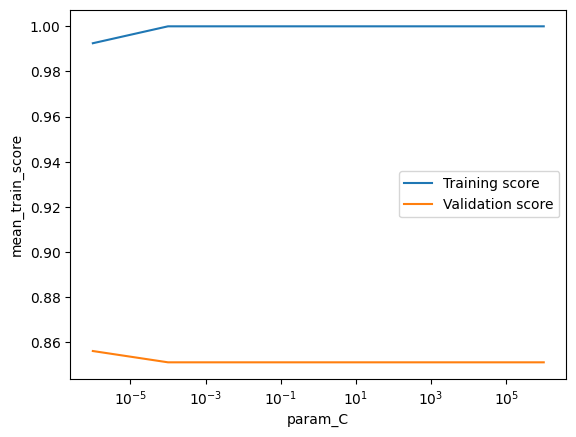

In [10]:
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_train_score', label="Training score");
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_test_score', label="Validation score");
plt.xscale('log');

It looks like we get a slightly better validation score near the smaller values for $C$! What does this mean?

Let’s try:

In [11]:
param_grid = [
  {'C': np.linspace(1e-5, 1e-7, num=10), 'kernel': ['linear']},
 ]
param_grid

[{'C': array([1.0e-05, 8.9e-06, 7.8e-06, 6.7e-06, 5.6e-06, 4.5e-06, 3.4e-06,
         2.3e-06, 1.2e-06, 1.0e-07]),
  'kernel': ['linear']}]

In [12]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 15.6 ms
Wall time: 1.49 s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([1.0e-05, 8.9e-06, 7.8e-06, 6.7e-06, 5.6e-06, 4.5e-06, 3.4e-06,
       2.3e-06, 1.2e-06, 1.0e-07]),
                          'kernel': ['linear']}],
             return_train_score=True, verbose=100)

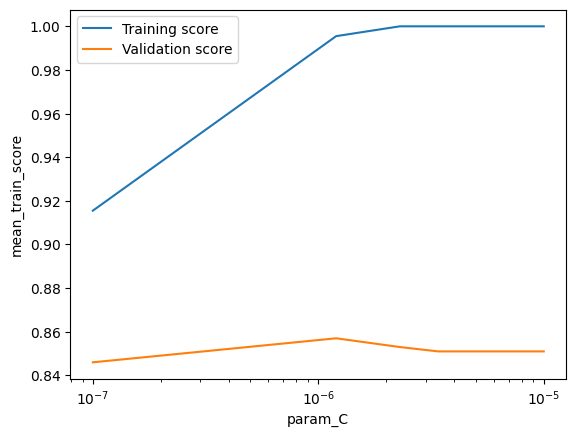

In [13]:
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_train_score', label="Training score");
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_C', y='mean_test_score', label="Validation score");
plt.xscale('log');

We can be satisfied that we have found a good hyperparameter only when we see the high bias AND high variance side of the validation curve!

### RBF kernel

Now, let’s look at the RBF kernel.

In our first search, the accuracy of the RBF kernel is very poor. We may have high bias, high variance, (or both).

When $C=0.1$ in our first search, both training and validation scores were low. This suggests high bias.

When $C=1000$ in our first search, training scores were high and validation scores were low. This suggests high variance.

What next? We know from our discussion of bias and variance of SVMs that to combat overfitting, we can decrease $\gamma$ and/or decrease $C$.

For now, let’s keep the higher value of $C$, and try to reduce the overfitting by decreasing $\gamma$.

In [14]:
param_grid = [
  {'C': [1000], 'gamma': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11], 'kernel': ['rbf']},
 ]
param_grid

[{'C': [1000],
  'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11],
  'kernel': ['rbf']}]

In [15]:
clf = GridSearchCV(SVC(), param_grid, cv=2, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
CPU times: total: 15.6 ms
Wall time: 1.09 s


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1000],
                          'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09,
                                    1e-10, 1e-11],
                          'kernel': ['rbf']}],
             return_train_score=True, verbose=100)

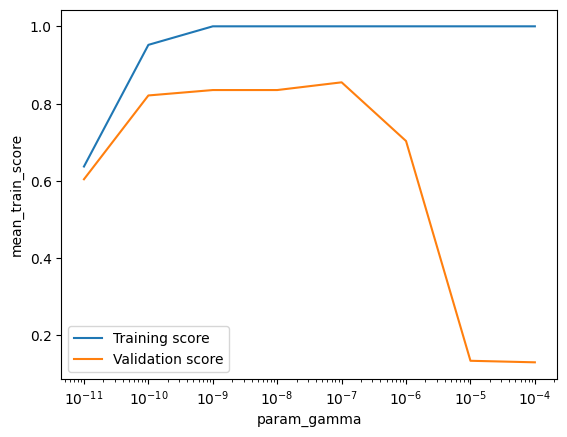

In [16]:
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_gamma', y='mean_train_score', label="Training score")
sns.lineplot(data=pd.DataFrame(clf.cv_results_), x='param_gamma', y='mean_test_score', label="Validation score")
plt.xscale('log');

Here, we see that (at least for $C=1000$), values of $\gamma$ greater than `1e-5` seem to overfit, while decreasing $\gamma$ lower than `1e-10` may underfit.

But we know that changing $C$ also affects the bias variance tradeoff! For different values of $C$, the best value of $\gamma$ will be different, and there may be a better *combination* of $C$ and $\gamma$ than any we have seen so far. We can try to increase and decrease $C$ to see if that improves the validation score.

Now that we have a better idea of where to search, we can set up our “final” search grid.

We know that to find the best validation accuracy for the linear kernel, we should make sure our search space includes `1e-6` and `1e-7`. I chose to vary $C$ from `1e-8` to `1e-4`. (I want to make sure the best value is not at the edge of the search space, so that we can be sure there isn’t a better value if we go lower/higher.)

We know that to find the best validation accuracy for the RBF kernel, we should make sure our search space includes $\gamma$ values around `1e-6` and `1e-7` when $C=1000$. For larger values of $C$, we expect that we’ll get better results with smaller values of $\gamma$. For smaller values of $C$, we expect that we’ll get better results with larger values of $\gamma$. I chose to vary $C$ from `1` to `1e6` and $\gamma$ from `1e-4` to `1e-11`.

That’s a big search grid, so this takes a long time to fit! (Try this at home with a larger training set to get an idea...)

In [17]:
param_grid = [
  {'C': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4], 'kernel': ['linear']},
  {'C': [1, 1e2, 1e3, 1e4, 1e5, 1e6], 'gamma': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11], 'kernel': ['rbf']},
 ]
param_grid

[{'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001], 'kernel': ['linear']},
 {'C': [1, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
  'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11],
  'kernel': ['rbf']}]

In [18]:
clf = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 53 candidates, totalling 159 fits
CPU times: total: 578 ms
Wall time: 12.3 s


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001],
                          'kernel': ['linear']},
                         {'C': [1, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0],
                          'gamma': [0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09,
                                    1e-10, 1e-11],
                          'kernel': ['rbf']}],
             return_train_score=True, verbose=100)

For the linear kernel, here's what we found:

In [19]:
df_cv   = pd.DataFrame(clf.cv_results_)
df_cv = df_cv[df_cv['param_kernel']=='linear']

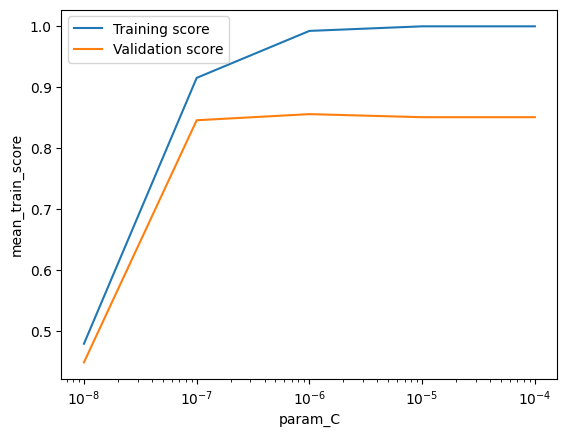

In [20]:
sns.lineplot(data=df_cv, x='param_C', y='mean_train_score', label="Training score")
sns.lineplot(data=df_cv, x='param_C', y='mean_test_score', label="Validation score")
plt.xscale('log');

For the RBF kernel, here's what we found:

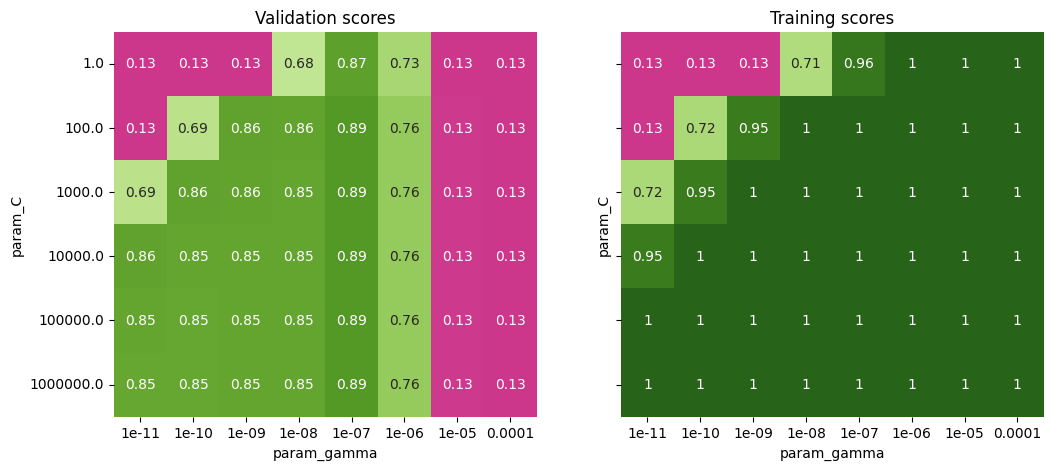

In [21]:
df_cv   = pd.DataFrame(clf.cv_results_)
df_cv = df_cv[df_cv['param_kernel']=='rbf']

plt.figure(figsize=(12,5))

ax1=plt.subplot(1,2,1)
pvt = pd.pivot_table(df_cv, values='mean_test_score', index='param_C', columns='param_gamma')
sns.heatmap(pvt, annot=True, cbar=False, vmin=0, vmax=1, cmap='PiYG');
plt.title("Validation scores");

ax2=plt.subplot(1,2,2, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
pvt = pd.pivot_table(df_cv, values='mean_train_score', index='param_C', columns='param_gamma')
sns.heatmap(pvt, annot=True, cbar=False, vmin=0, vmax=1, cmap='PiYG');
plt.title("Training scores");

We see that $\gamma$ and $C$ control the bias-variance tradeoff of the SVM model as follows.

-   In the top left region, $C$ is small (the margin is wider) and $\gamma$ is small (the kernel bandwidth is large). In this region, the model has more bias (is prone to underfit). The validation scores and training scores are both low.
-   On the right side (and we'd expect to see this on the bottom right if we extend the range of $C$ even higher), $C$ is large (the margin is narrower) and $\gamma$ is large (the kernel bandwidth is small. In this region, the model has more variance (is likely to overfit). The validation scores are low, but the training scores are high.

In the middle, we have a region of good combinations of $C$ and $\gamma$.

Since the parameter grid above shows us the validation accuracy decreasing both as we increase each parameter\* and also as we decrease each parameter, we can be a bit more confident that we captured the point in the bias-variance surface where the error is smallest.

\* $C$ is different because increasing $C$ even more may not actually change the margin.

We can see the “best” parameters, with which the model was re-fitted:

In [22]:
print(clf.best_params_)

{'C': 100.0, 'gamma': 1e-07, 'kernel': 'rbf'}


And we can evaluate the re-fitted model on the test set. (Note that the `GridSearchCV` only used the training set; we have not used the test set at all for model fitting.)

In [23]:
y_pred = clf.predict(X_test)

In [24]:
accuracy_score(y_pred, y_test)

0.89

## Random search

Our grid search found a pretty good set of hyperparameters, but it took a long time - about 100 seconds.

With a random search, we may be able to find hyperparameters that are still pretty good, in much less time.

We will search a similar range of parameters, although focusing only on the RBF kernel. But instead of specifying points on a grid like

    param_grid = [
      {'C': [1, 1e2, 1e3, 1e4, 1e5, 1e6], 'gamma': [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11], 'kernel': ['rbf']},
     ]

we will specify distributions from which to sample:

In [25]:
param_grid = [
  {'C': loguniform(1, 1e6), 'gamma': loguniform(1e-11, 1e-4), 'kernel': ['rbf']},
 ]

and then we will specify the total number of points to sample - 10, in this example:

In [26]:
clf = RandomizedSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True,  n_iter = 10)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 31.2 ms
Wall time: 2.68 s


RandomizedSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002F5D6BE7810>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002F5D7959590>,
                                         'kernel': ['rbf']}],
                   return_train_score=True, verbose=100)

In [27]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.220705,0.011991,0.347230,0.047354,5350.872775,9.652346e-10,rbf,"{'C': 5350.872774721334, 'gamma': 9.6523457101...",0.862275,0.864865,0.831832,0.852991,0.014999,3,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.165719,0.026584,0.301658,0.080126,21873.368635,3.178940e-10,rbf,"{'C': 21873.36863469877, 'gamma': 3.1789396204...",0.862275,0.861862,0.831832,0.851990,0.014255,5,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.225569,0.033673,0.309125,0.030913,142.150283,2.604799e-08,rbf,"{'C': 142.15028316840161, 'gamma': 2.604798537...",0.865269,0.876877,0.849850,0.863999,0.011070,1,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.329455,0.075246,0.508377,0.074699,3.678756,3.660170e-09,rbf,"{'C': 3.6787561221279983, 'gamma': 3.660169904...",0.733533,0.747748,0.729730,0.737003,0.007754,6,0.770270,0.766117,0.806597,0.780995,0.018183
4,0.170159,0.011421,0.254222,0.008225,13059.374244,1.201609e-09,rbf,"{'C': 13059.374243601183, 'gamma': 1.201609183...",0.862275,0.864865,0.831832,0.852991,0.014999,3,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.378783,0.044579,0.503279,0.037717,1283.304729,1.061103e-06,rbf,"{'C': 1283.3047293848333, 'gamma': 1.061102827...",0.733533,0.714715,0.702703,0.716983,0.012688,7,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.175397,0.024869,0.330116,0.053648,149.476224,6.118545e-10,rbf,"{'C': 149.47622402323307, 'gamma': 6.118544623...",0.865269,0.864865,0.855856,0.861997,0.004345,2,0.939940,0.940030,0.941529,0.940500,0.000729
7,0.431104,0.015712,0.458750,0.004166,6.303358,1.850665e-10,rbf,"{'C': 6.30335751404666, 'gamma': 1.85066496940...",0.128743,0.132132,0.129129,0.130001,0.001515,9,0.130631,0.128936,0.130435,0.130000,0.000757
8,0.376860,0.033743,0.464896,0.031108,42.518993,1.064213e-11,rbf,"{'C': 42.5189930933696, 'gamma': 1.06421315717...",0.128743,0.132132,0.129129,0.130001,0.001515,9,0.130631,0.128936,0.130435,0.130000,0.000757
9,0.474602,0.041371,0.414173,0.016521,741.646004,9.580432e-06,rbf,"{'C': 741.646003718711, 'gamma': 9.58043180493...",0.134731,0.135135,0.138138,0.136001,0.001520,8,1.000000,1.000000,1.000000,1.000000,0.000000


In [28]:
print(clf.best_params_)

{'C': np.float64(142.15028316840161), 'gamma': np.float64(2.6047985378173488e-08), 'kernel': 'rbf'}


In [29]:
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8633333333333333

Our random search can find a good solution, in only about ~20 seconds. However, depending on the random samples it chooses, it may be a better solution or a worse solution than the one we found via grid search.

## Adaptive Search (Bayes Search)

Finally, we’ll consider one other type of hyperparameter optimization: we will look at an adaptive search that uses information about the models it has seen so far in order to decide which part of the hyperparameter space to sample from next.

We will install the `scikit-optimize` package, which provides `BayesSearchCV`.

In [30]:
!pip install scikit-optimize

In [31]:
from skopt import BayesSearchCV
from skopt.plots import plot_evaluations

We will define the search space:

In [32]:
param_grid = [
  {'C': (1, 1e6, 'log-uniform'), 'gamma': (1e-11, 1e-4, 'log-uniform'), 'kernel': ['rbf']},
 ]

As before, we will specify the total number of points to sample - 5, in this example:

In [33]:
clf = BayesSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=100, n_jobs=-1, return_train_score=True,  n_iter = 5)
%time clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 0 ns
Wall time: 2.18 s


BayesSearchCV(cv=3, estimator=SVC(), n_iter=5, n_jobs=-1,
              return_train_score=True,
              search_spaces=[{'C': (1, 1000000.0, 'log-uniform'),
                              'gamma': (1e-11, 0.0001, 'log-uniform'),
                              'kernel': ['rbf']}],
              verbose=100)

In [34]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,rank_train_score
0,0.069479,0.001641,0.071364,0.003330,16697.283616,4.739841e-09,rbf,"{'C': 16697.283615919347, 'gamma': 4.739840979...",0.862275,0.864865,0.834835,0.853992,0.013587,3,1.00000,1.000000,1.000000,1.000000,0.000000,1
1,0.140554,0.006293,0.110267,0.000533,17.662082,4.941769e-05,rbf,"{'C': 17.662082352917412, 'gamma': 4.941769102...",0.128743,0.132132,0.129129,0.130001,0.001515,5,1.00000,1.000000,1.000000,1.000000,0.000000,1
2,0.072819,0.003188,0.076905,0.003331,165.884723,6.037198e-10,rbf,"{'C': 165.88472325752753, 'gamma': 6.037198165...",0.862275,0.867868,0.852853,0.860999,0.006196,1,0.95045,0.946027,0.943028,0.946502,0.003049,5
3,0.061429,0.005222,0.075994,0.002794,406314.295872,1.910994e-08,rbf,"{'C': 406314.29587153357, 'gamma': 1.910993970...",0.865269,0.870871,0.846847,0.860996,0.010263,2,1.00000,1.000000,1.000000,1.000000,0.000000,1
4,0.145604,0.003647,0.111045,0.009533,6140.100079,6.651973e-06,rbf,"{'C': 6140.100078550409, 'gamma': 6.6519734872...",0.155689,0.174174,0.150150,0.160004,0.010272,4,1.00000,1.000000,1.000000,1.000000,0.000000,1


In [35]:
print(clf.best_params_)

OrderedDict([('C', 165.88472325752753), ('gamma', 6.03719816565209e-10), ('kernel', 'rbf')])


In [36]:
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8666666666666667

To see how this works, we will re-run the Bayes search with more iterations than we really need, just so that we can visualize how it searches the hyperparameter space.

In [37]:
clf = BayesSearchCV(SVC(), param_grid, cv=3, refit=False, verbose=100, n_jobs=-1, n_iter = 50)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 1e-11, np.str_('rbf')] before, using random point [67.65402352659673, 1.4894919134619606e-08, 'rbf']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 1e-11, np.str_('rbf')] before, using random point [539227.9380820844, 3.059324995159682e-06, 'rbf']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 1e-11, np.str_('rbf')] before, using random point [682751.5960238439, 2.681329962183629e-10, 'rbf']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 1e-11, np.str_('rbf')] before, using random point [8.588961153316108, 6.039836428671602e-05, 'rbf']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 1e-11, np.str_('rbf')] before, using random point [129.8937925873837, 8.697234727052093e-05, 'rbf']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 1e-11, np.str_('rbf')] before, using random point [3.2023250364060583, 4.3715254396437944e-10, 'rbf']
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3, estimator=SVC(), n_jobs=-1, refit=False,
              search_spaces=[{'C': (1, 1000000.0, 'log-uniform'),
                              'gamma': (1e-11, 0.0001, 'log-uniform'),
                              'kernel': ['rbf']}],
              verbose=100)

<Axes: >

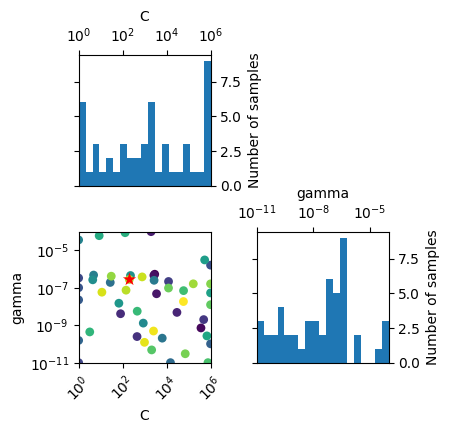

In [38]:
plot_evaluations(clf.optimizer_results_[0])

This creates a grid of plots as follows:

-   the diagonal plots are histograms, that show the distribution of samples for each hyperparameter.
-   the scatter plot shows the samples in the hyperparameter space that were “visited”, and the order in which they were “visited” is encoded i the point’s color. A red star shows the best hyperparameters that we found.

In [39]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.142254,0.002589,0.095229,0.006974,2883.203775,5.275713e-07,rbf,"{'C': 2883.2037745693005, 'gamma': 5.275712767...",0.895210,0.903904,0.879880,0.892998,0.009932,12
1,0.061536,0.005677,0.077591,0.001032,366282.624754,7.135722e-10,rbf,"{'C': 366282.62475396943, 'gamma': 7.135721548...",0.862275,0.861862,0.831832,0.851990,0.014255,36
2,0.128775,0.003349,0.087831,0.002503,2641.704230,4.606762e-07,rbf,"{'C': 2641.7042301217443, 'gamma': 4.606762352...",0.907186,0.903904,0.885886,0.898992,0.009364,6
3,0.079412,0.003902,0.085269,0.005537,3493.717099,4.775767e-08,rbf,"{'C': 3493.717099101768, 'gamma': 4.7757668015...",0.868263,0.891892,0.864865,0.875007,0.012020,20
4,0.175893,0.011311,0.132010,0.005949,1971.822457,9.904878e-05,rbf,"{'C': 1971.8224568554185, 'gamma': 9.904878459...",0.128743,0.132132,0.129129,0.130001,0.001515,44
5,0.062485,0.004804,0.065003,0.000546,29572.978314,4.824468e-09,rbf,"{'C': 29572.97831378516, 'gamma': 4.8244683686...",0.862275,0.864865,0.834835,0.853992,0.013587,30
6,0.063769,0.001880,0.071685,0.004210,80.736487,4.096584e-09,rbf,"{'C': 80.73648691499025, 'gamma': 4.0965842963...",0.850299,0.870871,0.858859,0.860010,0.008438,27
7,0.075274,0.006620,0.081947,0.005506,453.214454,2.472249e-10,rbf,"{'C': 453.21445388799276, 'gamma': 2.472248538...",0.868263,0.864865,0.849850,0.860993,0.008000,26
8,0.056531,0.005307,0.079922,0.006317,486782.394360,1.990248e-09,rbf,"{'C': 486782.3943603459, 'gamma': 1.9902477531...",0.862275,0.864865,0.834835,0.853992,0.013587,30
9,0.115305,0.007236,0.099503,0.003756,12268.293816,2.159777e-07,rbf,"{'C': 12268.293816237734, 'gamma': 2.159777362...",0.889222,0.900901,0.897898,0.896007,0.004952,9
